# Goals

#### Predict Gender and age in given groups based on the datasets provided 
These datasets come in csv files connected by different identification keys. 

# Understand the data
This is crucial! There are basic explanations on the competitions [website](https://www.kaggle.com/c/talkingdata-mobile-user-demographics/data). Here is the data connection diagramm given:
![Data diagramm](data_tree.png)

We also already now that the company names are provided in chinese, which is not particularly helpful. Then, we see that the apps already are categorised, which is handy. However, doubt is present that the variable can be used out-of-the box.

In [1]:
# Set input dir
import sys
# perform imports so that we can use single cells w/o worrying about imports
import pandas as pd
from pandas import DataFrame as df
import IPython as ip

import seaborn as sns
sns.set(color_codes=True)
sns.set_context('poster',rc={"figure.figsize": (24, 10)})
sns.set_style('ticks')

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
sys.path.append("/home/mschlupp/pythonTools")
tmp = %pwd
files_dir = tmp + "/files/" 

#### Load some nice colors from [my github](https://github.com/mschlupp/pythonTools/tree/master/plotting).
Then delete a few lines of the original file to make the code a bit leaner.

In [3]:
# %load '/home/mschlupp/pythonTools/plotting/nice_colors.py'

'''
Color dictionaries from 
http://tableaufriction.blogspot.de/2012/11/finally-you-can-use-tableau-data-colors.html
'''

Tableau10_Medium = { 
	"blue"   : (114/255.,158/255.,206/255.),
	"orange" : (255/255.,158/255.,74/255.),
	"green"  : (103/255.,191/255.,92/255.),
	"red"    : (237/255.,102/255.,93/255.),
	"purple" : (173/255.,139/255.,201/255.),
	"brown"  : (168/255.,120/255.,110/255.),
	"pink"   : (237/255.,151/255.,202/255.),
	"gray"   : (162/255.,162/255.,162/255.),
	"olive"  : (205/255.,204/255.,93/255.),
	"cyan"   : (109/255.,204/255.,218/255.)
}

ColorBlind10 = {
	"azure"        : (0./255.,107./255.,164/255.),
	"orange"       : (255./255.,128./255.,14/255.),
	"grey_medium"  : (171./255.,171./255.,171/255.),
	"grey_dark"    : (89./255.,89./255.,89/255.),
	"blue_medium"  : (95./255.,158./255.,209/255.),
	"orange_dark"  : (200./255.,82./255.,0/255.),
	"grey"         : (137./255.,137./255.,137/255.),
	"blue_light"   : (162./255.,200./255.,236/255.),
	"orange_light" : (255./255.,188./255.,121/255.),
	"grey_light"   : (207./255.,207./255.,207/255.)
}

We left of the first notebook, `1_understand_data`, with a merged data file. We will load it first.

In [4]:
traintest_phone = pd.read_csv(files_dir+'traintest_phone.csv',index_col=0)
traintest_phone.head(2)

,age,device_id,gender,group,isTrain,phone_brand,device_model
0,35,-8076087639492063270,M,M32-38,1,小米,MI 2
1,35,-2897161552818060146,M,M32-38,1,小米,MI 2


In [5]:
# Now we load the events data
events = pd.read_csv(files_dir+'events.csv')
events.head(2)

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97


In [6]:
# load other functions from my github, and delete lines.
# %load /home/mschlupp/pythonTools/utilities.py
'''
Module containing small general helper functions
'''

def showUniques(df):
		"""
		Helper function that shows unique entries per DataFrame column.

		Arguments:
		df: the pandas DataFrame in question.
		"""
		
		import pandas as pd
		from pandas import DataFrame 

		print("Number of rows: ", len(df))
		print("Number of unique values per column: ")
		for col in df.columns:
				print("Column {}: ".format(col), df[col].nunique())


In [7]:
print('gender: ')
showUniques(traintest_phone)
print('=======================','\nevents: ')
showUniques(events)

gender: 
Number of rows:  186716
Number of unique values per column: 
Column age:  86
Column device_id:  186716
Column gender:  3
Column group:  13
Column isTrain:  2
Column phone_brand:  131
Column device_model:  1599
events: 
Number of rows:  3252950
Number of unique values per column: 
Column event_id:  3252950
Column device_id:  60865
Column timestamp:  588125
Column longitude:  3588
Column latitude:  3086


In [8]:
traintest_phone.isTrain[traintest_phone.device_id.isin(events.device_id)].describe()

count    58503.000000
mean         0.398424
std          0.489578
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: isTrain, dtype: float64

In [9]:
# being paranoid again...
train = pd.read_csv('files/gender_age_train.csv')
test = pd.read_csv('files/gender_age_test.csv')

In [10]:
tr = train.device_id.isin(events.device_id)
te = test.device_id.isin(events.device_id)

In [11]:
print(tr.value_counts())#.apply(lambda x: x/len(tr.index)))
print(te.value_counts())#.apply(lambda x: x/len(te.index)))

False    51336
True     23309
Name: device_id, dtype: int64
False    76877
True     35194
Name: device_id, dtype: int64


This comes as a surprise. Only ~31% of the `device_id`s have event information available. At least the percentage is basically the same in the training and testing set.

Can we learn something from this?

In [12]:
try:
    traintest_phone['hasEvents'] = 1 if traintest_phone.device_id.isin(events.device_id) else 0
except ValueError:
    print('This does not seem to work. :(')
    traintest_phone['hasEvents'] = 0
    traintest_phone.hasEvents[traintest_phone.device_id.isin(events.device_id)] = 1
    

This does not seem to work. :(


/home/mschlupp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
traintest_phone.head(3)

,age,device_id,gender,group,isTrain,phone_brand,device_model,hasEvents
0,35,-8076087639492063270,M,M32-38,1,小米,MI 2,0
1,35,-2897161552818060146,M,M32-38,1,小米,MI 2,0
2,35,-8260683887967679142,M,M32-38,1,小米,MI 2,1


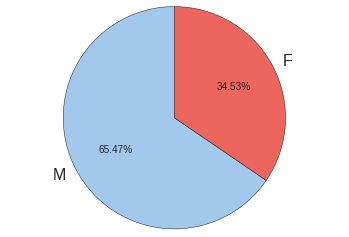

In [14]:
plt.pie(traintest_phone.gender[(traintest_phone.hasEvents==1) & (traintest_phone.isTrain==1)].value_counts(),
       colors=[ColorBlind10['blue_light'],Tableau10_Medium['red']],
       labels=traintest_phone.gender[traintest_phone.isTrain==1].value_counts().index, autopct='%2.2f%%', startangle=90);
plt.axis('equal');


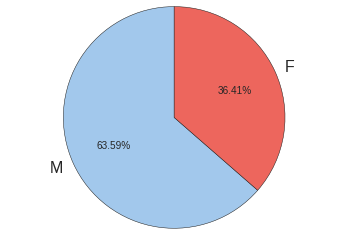

In [15]:
plt.pie(traintest_phone.gender[(traintest_phone.hasEvents==0) & (traintest_phone.isTrain==1)].value_counts(),
       colors=[ColorBlind10['blue_light'],Tableau10_Medium['red']],
       labels=traintest_phone.gender[traintest_phone.isTrain==1].value_counts().index, autopct='%2.2f%%', startangle=90);
plt.axis('equal');

Ok, no big differents in gender (original relations: 64.18% male and 35.82% female). How about age?

/home/mschlupp/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


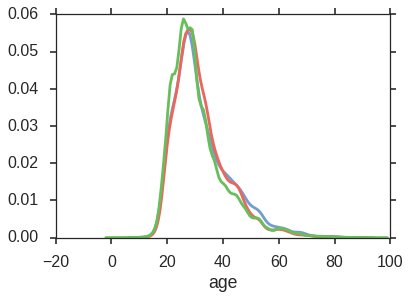

In [16]:
sns.distplot(traintest_phone.age[(traintest_phone.isTrain==1) 
                                 & (traintest_phone.hasEvents==1)
                                & (traintest_phone.gender=='F')],
            color=Tableau10_Medium['blue'], hist=False,
            bins=80);

sns.distplot(traintest_phone.age[(traintest_phone.isTrain==1) 
                                 & (traintest_phone.hasEvents==1)
                                & (traintest_phone.gender=='M')],
            color=Tableau10_Medium['red'], hist=False,
            bins=80);

sns.distplot(traintest_phone.age[(traintest_phone.isTrain==1)
                                 & (traintest_phone.hasEvents==0)],
            color=Tableau10_Medium['green'], hist=False,
            bins=80);


Only very slight differences.

In [17]:
print(len(events))
events.head(2)

3252950


,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97


We can probably learn something from the number of events per `device_id`.

In [18]:
evts = events.groupby('device_id')

In [19]:
nhits = evts.event_id.count()
nhits.head(4)

device_id
-9222956879900151005    65
-9222661944218806987     8
-9222399302879214035    10
-9221825537663503111    99
Name: event_id, dtype: int64

In [20]:
nhits[-9222661944218806987]

8

In [21]:
indx = traintest_phone.device_id[traintest_phone.device_id.isin(events.device_id)]
indx.head(2)

2    -8260683887967679142
11    7477216237379271436
Name: device_id, dtype: int64

In [22]:
print(len(indx),len(nhits))

58503 60865


In [23]:
traintest_phone['nEvts']=0 # first set all nEvts to 0 as most have no event info available

In [24]:
# Now drop all the device_ids that are not in the training or test set
nhits = nhits[nhits.index.isin(traintest_phone.device_id)]
len(nhits)

58503

In [26]:
traintest_phone.nEvts.iloc[indx.index] = [nhits[x] for x in indx]
traintest_phone.head(3)
# this is way too slow
#for i,x in enumerate(traintest_phone.iloc[indx.index].iterrows()):
#    #print(x)
#    traintest_phone.nEvts[x[0]]=nhits[x[1]['device_id']]
#    if i % 5001 == 0:
#        print(x[1]['nEvts'], x[1]['device_id'])
#        print(float(i)/len(indx)*100, " percent done.")

/home/mschlupp/anaconda3/lib/python3.5/site-packages/pandas-0.17.1-py3.5-linux-x86_64.egg/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,age,device_id,gender,group,isTrain,phone_brand,device_model,hasEvents,nEvts
0,35,-8076087639492063270,M,M32-38,1,小米,MI 2,0,0
1,35,-2897161552818060146,M,M32-38,1,小米,MI 2,0,0
2,35,-8260683887967679142,M,M32-38,1,小米,MI 2,1,1


### Further ideas:
use mean & spread of the latitude and longitude. 

In [28]:
traintest_phone.to_csv(files_dir+'traintest_phone_evts.csv')

In [29]:
len(evts.longitude.mean())

60865

In [30]:
# calculate mean and variance of longitude and latitude
# reduce to relevant device_ids 

long_mean = evts.longitude.mean()
long_mean = long_mean[long_mean.index.isin(traintest_phone.device_id)]
long_var = evts.longitude.var()
long_var = long_var[long_var.index.isin(traintest_phone.device_id)]

lat_mean = evts.latitude.mean()
lat_mean = lat_mean[lat_mean.index.isin(traintest_phone.device_id)]
lat_var = evts.latitude.var()
lat_var = lat_var[lat_var.index.isin(traintest_phone.device_id)]


In [31]:
# Give default values our new values
traintest_phone['longitude_mean'] =-1
traintest_phone['longitude_variance'] =-1
traintest_phone['latitude_mean'] =-1
traintest_phone['latitude_variance'] =-1

In [32]:
# set values to mean and var values

traintest_phone.longitude_mean.iloc[indx.index] = [long_mean[x] for x in indx]
traintest_phone.longitude_variance.iloc[indx.index] = [long_var[x] for x in indx]
traintest_phone.latitude_mean.iloc[indx.index] = [lat_mean[x] for x in indx]
traintest_phone.latitude_variance.iloc[indx.index] = [lat_var[x] for x in indx]

/home/mschlupp/anaconda3/lib/python3.5/site-packages/pandas-0.17.1-py3.5-linux-x86_64.egg/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [33]:
traintest_phone.latitude_variance[traintest_phone.latitude_variance.isnull()]=-1
traintest_phone.longitude_variance[traintest_phone.longitude_variance.isnull()]=-1

/home/mschlupp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/mschlupp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Format the timestamp
First, we split the timestamp into day and time. 

This doesn't make sense right now. It is not yet a variable that can be grouped to device id.
So first we add these to the events data.

In [34]:
events['day'] = events.timestamp.apply(lambda x: x.split()[0])
events['time'] = events.timestamp.apply(lambda x: x.split()[1])

In [35]:
events.day.unique()

array(['2016-05-01', '2016-04-30', '2016-05-02', '2016-05-03',
       '2016-05-04', '2016-05-05', '2016-05-06', '2016-05-07', '2016-05-08'], dtype=object)

Ok there are only nine days, lets translate these into weekdays:
   * 2016-04-30: Saturday
   * 2016-05-01: Sunday
   * 2016-05-02: Monday
   * 2016-05-03: Tuesday
   * 2016-05-04: Wednesday
   * 2016-05-05: Thursday
   * 2016-05-06: Friday
   * 2016-05-07: Saturday
   * 2016-05-08: Sunday

In [53]:
events.day[events.day=='2016-04-30'] = 'Sat';
events.day[events.day=='2016-05-01'] = 'Sun';
events.day[events.day=='2016-05-02'] = 'Mon';
events.day[events.day=='2016-05-03'] = 'Tue';
events.day[events.day=='2016-05-04'] = 'Wed';
events.day[events.day=='2016-05-05'] = 'Thu';
events.day[events.day=='2016-05-06'] = 'Fri';
events.day[events.day=='2016-05-07'] = 'Sat';
events.day[events.day=='2016-05-08'] = 'Sun';


/home/mschlupp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/mschlupp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/mschlupp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/mschlupp/anaconda3/l

In [37]:
# Split the time stamps into categories of hours

events['hour'] = events.time.apply(lambda x: x.split(sep=':')[0])

In [38]:
#tranform string to int feature with sklearn LabelEncoder
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
f=le.fit(events.hour)

In [39]:
events.hour = f.transform(events.hour)

In [62]:
events.tail()

,event_id,device_id,timestamp,longitude,latitude,day,time,hour,usageDay
3252945,3252946,-8995272658520685777,2016-05-07 23:14:17,0.00,0.00,Sat,23:14:17,23,2
3252946,3252947,6790350461641275817,2016-05-07 23:14:08,120.65,27.78,Sat,23:14:08,23,2
3252947,3252948,7111660304904287709,2016-05-07 23:35:33,121.40,31.18,Sat,23:35:33,23,2
3252948,3252949,2786044170600788970,2016-05-07 23:36:03,111.19,31.29,Sat,23:36:03,23,2
3252949,3252950,3315513013457872370,2016-05-07 23:20:08,112.99,28.23,Sat,23:20:08,23,2


In [55]:
events.to_csv(files_dir+'events_day_hour.csv')

In [56]:
traintest_phone.head(2)

,age,device_id,gender,group,isTrain,phone_brand,device_model,hasEvents,nEvts,longitude_mean,longitude_variance,latitude_mean,latitude_variance,usageTime_mean,usageTime_variance,usageDay_mean,usageDay_variance
0,35,-8076087639492063270,M,M32-38,1,小米,MI 2,0,0,-1,-1,-1,-1,-1,-1,-1,-1
1,35,-2897161552818060146,M,M32-38,1,小米,MI 2,0,0,-1,-1,-1,-1,-1,-1,-1,-1


Ok, we now simply calculate the mean usage time and day and the variances to check if this yields any information.
It is also a very quick feature we can create and then use it for classification.

In [57]:
hour_mean = evts.hour.mean()
hour_variance = evts.hour.var()

In [58]:
le_day = preprocessing.LabelEncoder()
le_day.fit(events.day)


LabelEncoder()

In [59]:
events['usageDay'] = le_day.transform(events.day)

In [69]:
evts = events.groupby('device_id')

In [74]:
day_mean = evts.usageDay.mean()
day_var = evts.usageDay.var()

In [71]:
le_day.classes_

array(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype=object)

In [48]:
traintest_phone['usageTime_mean']=-1
traintest_phone['usageTime_variance']=-1
traintest_phone['usageDay_mean']=-1
traintest_phone['usageDay_variance']=-1

In [73]:
indx.head(2)

2    -8260683887967679142
11    7477216237379271436
Name: device_id, dtype: int64

In [76]:
# indx holds indices that have device_ids in the events data file
traintest_phone.usageTime_mean.iloc[indx.index.values] = [hour_mean[x] for x in indx]
traintest_phone.usageTime_variance.iloc[indx.index.values] = [hour_variance[x] for x in indx]
traintest_phone.usageDay_mean.iloc[indx.index.values] = [day_mean[x] for x in indx]
traintest_phone.usageDay_variance.iloc[indx.index.values] = [day_var[x] for x in indx]

/home/mschlupp/anaconda3/lib/python3.5/site-packages/pandas-0.17.1-py3.5-linux-x86_64.egg/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [86]:
traintest_phone.usageTime_variance[traintest_phone.nEvts==1] = traintest_phone.usageDay_variance[traintest_phone.nEvts==1] = -1

/home/mschlupp/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [91]:
traintest_phone.to_csv(files_dir+'traintest_phone_day_hour.csv', index=False)

In [97]:
traintest_phone.iloc[15]

age                                    28
device_id             1508636020748379883
gender                                  F
group                              F27-28
isTrain                                 1
phone_brand                            华为
device_model                       荣耀畅玩4X
hasEvents                               1
nEvts                                  35
longitude_mean                    120.256
longitude_variance            2.47059e-05
latitude_mean                      31.898
latitude_variance             5.76471e-05
usageTime_mean                       14.8
usageTime_variance                10.4588
usageDay_mean                     4.57143
usageDay_variance                 1.84034
Name: 15, dtype: object

In [192]:
def compareDistributionsTo(feature, data, labels = None, bins = 40, palette = None):
    for i,d in enumerate(data):
        a = sns.distplot(d[feature],
                color=list(palette.values())[i] if palette else sns.color_palette("Set2", len(data))[i], 
                label= labels[i] if labels else 'data{}'.format(i),
                hist=True,
                kde=False, norm_hist=True,
                bins=bins);
        
    return a

In [204]:
sets= [traintest_phone[(traintest_phone.isTrain==1) & (traintest_phone.gender=='M') & (traintest_phone.nEvts>=1)],
    traintest_phone[(traintest_phone.isTrain==1) & (traintest_phone.gender=='F') & (traintest_phone.nEvts>=1)]]
                     

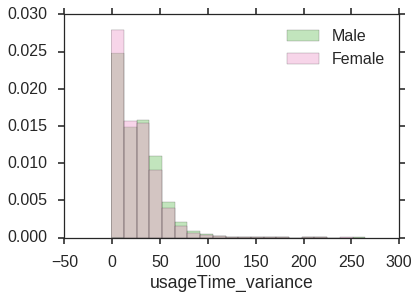

In [226]:
a = compareDistributionsTo('usageTime_variance', 
                     data=sets, bins=20,
                     labels=['Male', 'Female'],
                     palette=Tableau10_Medium
                    );
a.legend(loc='best');

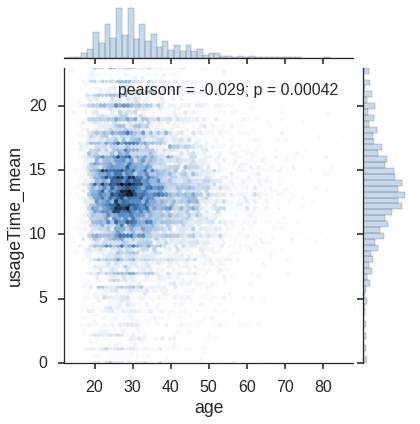

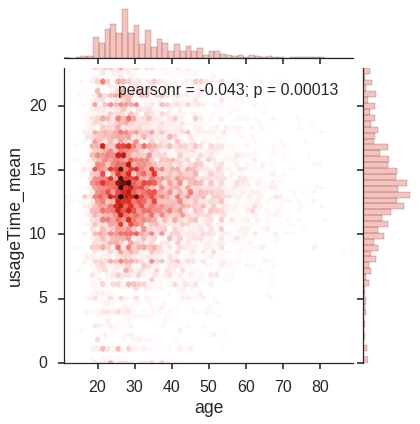

In [230]:
data = traintest_phone[(traintest_phone.isTrain==1) & (traintest_phone.nEvts>=1)]
sns.jointplot(sets[0].age,sets[0].usageTime_mean, kind='hex', color=Tableau10_Medium['blue'])
sns.jointplot(sets[1].age,sets[1].usageTime_mean, kind='hex', color=Tableau10_Medium['red'])


Minor differences in the variables, but still most of the entries don't even have event information. Let's safe for now and do a couple of predictions.

In [231]:
traintest_phone.to_csv(files_dir+'traintest_fullevt.csv', index=False)